Notebook to read all experimentations

In [16]:
import pickle
import pandas as pd
from fnmatch import fnmatch
import os
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
"""
Function to read a single experiment from file
"""
def read_experiment(model_name, target_column, max_time, is_homogenous_dataset=False, experiment_name=None):
    if is_homogenous_dataset:
        main_path = 'results/homogenous_data'
    else:
        main_path = 'results/non_homogenous_data'
        
    model_path = f'{main_path}/{target_column}/{max_time}/{model_name}'

    if experiment_name is None:
        model_path = model_path + '/defaultExperiment'
    else:
        model_path = model_path + f'/{experiment_name}'
        
    # Read model
    with open(f'{model_path}/model.sav', 'rb') as f:
        model = pickle.load(f)
    
    # Read auc statistic
    with open(f'{model_path}/auc_statistics.pkl', 'rb') as f:
        auc_stats = pickle.load(f)
    return model, auc_stats

In [3]:
# read all auc statistics and save as csv
root = 'results\\non_homogenous_data'
pattern = "*_statistics.pkl"
all_auc_statistics = pd.DataFrame()
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            filename = os.path.join(path, name)

            myfile = open(filename,"rb")
            temp = pickle.load(myfile)
            myfile.close()
            
            subdirectories = filename.split('\\')
            dataset_type = subdirectories[1]
            target_column = subdirectories[2]
            months_trained = subdirectories[3]
            model_name = subdirectories[4]
            experiment_name = subdirectories[5]
            
            temp['dataset_type'] = dataset_type
            temp['target_column'] = target_column
            temp['months_trained'] = months_trained
            temp['model_name'] = model_name
            temp['experiment_name'] = experiment_name
            
            all_auc_statistics = pd.concat([all_auc_statistics, temp])

all_auc_statistics.to_csv('all_auc_statistics.csv', index=False)

In [4]:
all_auc_statistics

,month,train_auc,test_auc,dataset_type,target_column,months_trained,model_name,experiment_name
0,6,0.945358,0.939377,non_homogenous_data,bcr,108,LogisticRegression,defaultExperiment
1,12,0.909996,0.888244,non_homogenous_data,bcr,108,LogisticRegression,defaultExperiment
2,18,0.891807,0.878229,non_homogenous_data,bcr,108,LogisticRegression,defaultExperiment
3,24,0.888124,0.863556,non_homogenous_data,bcr,108,LogisticRegression,defaultExperiment
4,30,0.876179,0.864646,non_homogenous_data,bcr,108,LogisticRegression,defaultExperiment
...,...,...,...,...,...,...,...,...
11,72,0.998503,0.933781,non_homogenous_data,mts,96,XGBClassifier,Experiment 001
12,78,0.998088,0.935347,non_homogenous_data,mts,96,XGBClassifier,Experiment 001
13,84,0.997699,0.935347,non_homogenous_data,mts,96,XGBClassifier,Experiment 001
14,90,0.996985,0.934004,non_homogenous_data,mts,96,XGBClassifier,Experiment 001


In [7]:
Path('eda/models').mkdir(parents=True, exist_ok=True)

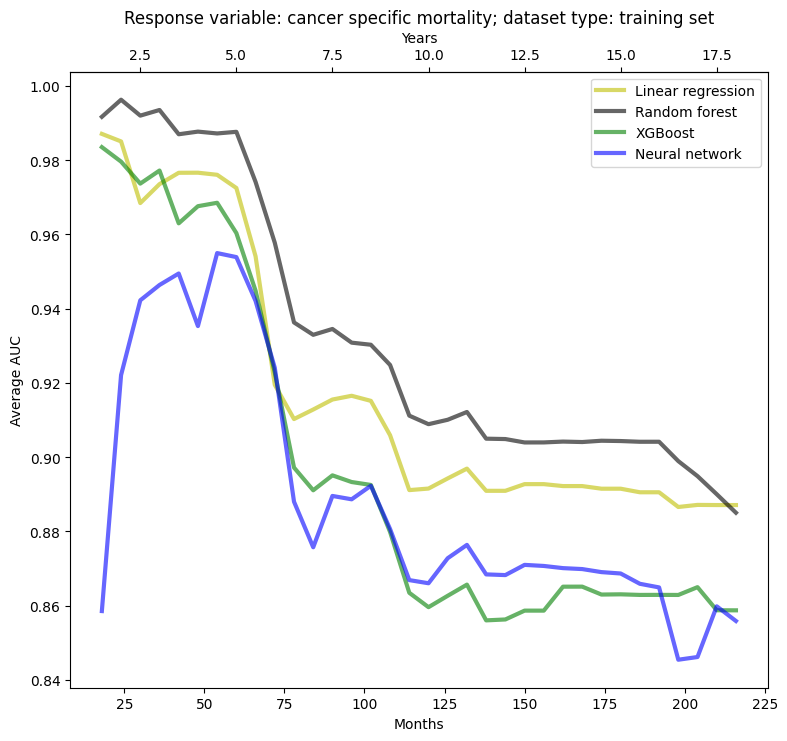

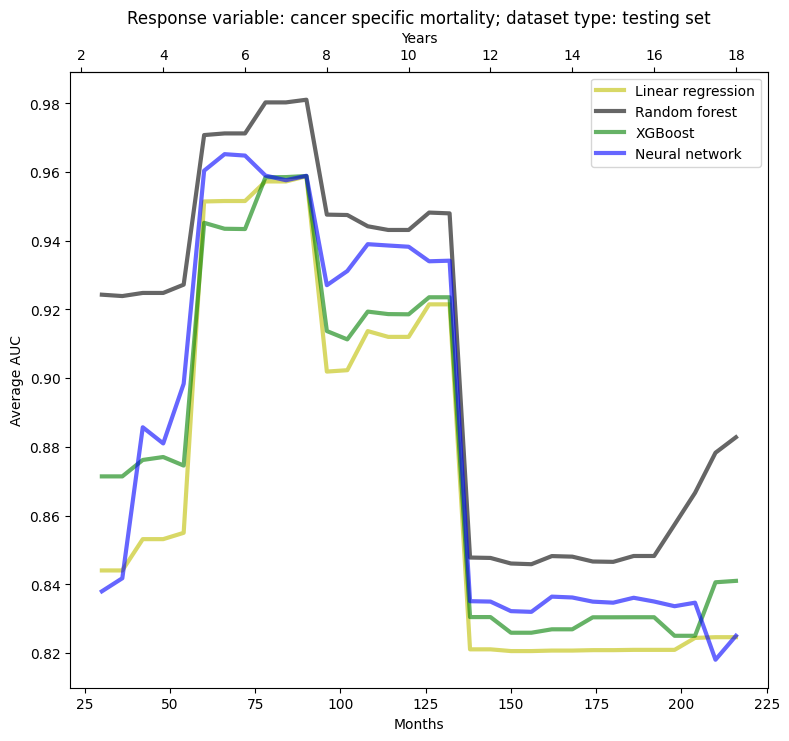

In [26]:
lr_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'cancer_specific_mortality') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'LogisticRegression') &
                                (all_auc_statistics.experiment_name == 'defaultExperiment')]

rf_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'cancer_specific_mortality') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'RandomForestClassifier') &
                                (all_auc_statistics.experiment_name == 'defaultExperiment')]

xgb_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'cancer_specific_mortality') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'XGBClassifier') &
                                (all_auc_statistics.experiment_name == 'defaultExperiment')]

nn_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'cancer_specific_mortality') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'MLPClassifier') &
                                (all_auc_statistics.experiment_name == 'Experiment 004')]

lr_optimal_aggregated = lr_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
rf_optimal_aggregated = rf_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
xgb_optimal_aggregated = xgb_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
nn_optimal_aggregated = nn_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()

# Plot 
fig, ax = plt.subplots()
fig.set_size_inches(9, 8, forward=True)

ax.plot(lr_optimal_aggregated['month'],lr_optimal_aggregated['train_auc'],
    alpha=0.6,color='y', linewidth=3)
ax.plot(rf_optimal_aggregated['month'],rf_optimal_aggregated['train_auc'],
    alpha=0.6,color='k', linewidth=3)
ax.plot(xgb_optimal_aggregated['month'],xgb_optimal_aggregated['train_auc'],
    alpha=0.6,color='g', linewidth=3)
ax.plot(nn_optimal_aggregated['month'],nn_optimal_aggregated['train_auc'],
    alpha=0.6,color='b', linewidth=3)

ax.legend(['Linear regression', 'Random forest', 'XGBoost', 'Neural network'])

ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
ax2.set_xlabel("Years")

ax.set_xlabel('Months')
ax.set_ylabel('Average AUC')

plt.title('Response variable: cancer specific mortality; dataset type: training set')
plt.savefig('eda/models/cancer_specific_mortality-training_set.png', dpi=500, bbox_inches='tight')
plt.show()


# Plot 
fig, ax = plt.subplots()
fig.set_size_inches(9, 8, forward=True)

ax.plot(lr_optimal_aggregated['month'],lr_optimal_aggregated['test_auc'],
    alpha=0.6,color='y', linewidth=3)
ax.plot(rf_optimal_aggregated['month'],rf_optimal_aggregated['test_auc'],
    alpha=0.6,color='k', linewidth=3)
ax.plot(xgb_optimal_aggregated['month'],xgb_optimal_aggregated['test_auc'],
    alpha=0.6,color='g', linewidth=3)
ax.plot(nn_optimal_aggregated['month'],nn_optimal_aggregated['test_auc'],
    alpha=0.6,color='b', linewidth=3)

ax.legend(['Linear regression', 'Random forest', 'XGBoost', 'Neural network'])

ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
ax2.set_xlabel("Years")

ax.set_xlabel('Months')
ax.set_ylabel('Average AUC')

plt.title('Response variable: cancer specific mortality; dataset type: testing set')
plt.savefig('eda/models/cancer_specific_mortality-testing_set.png', dpi=500, bbox_inches='tight')
plt.show()

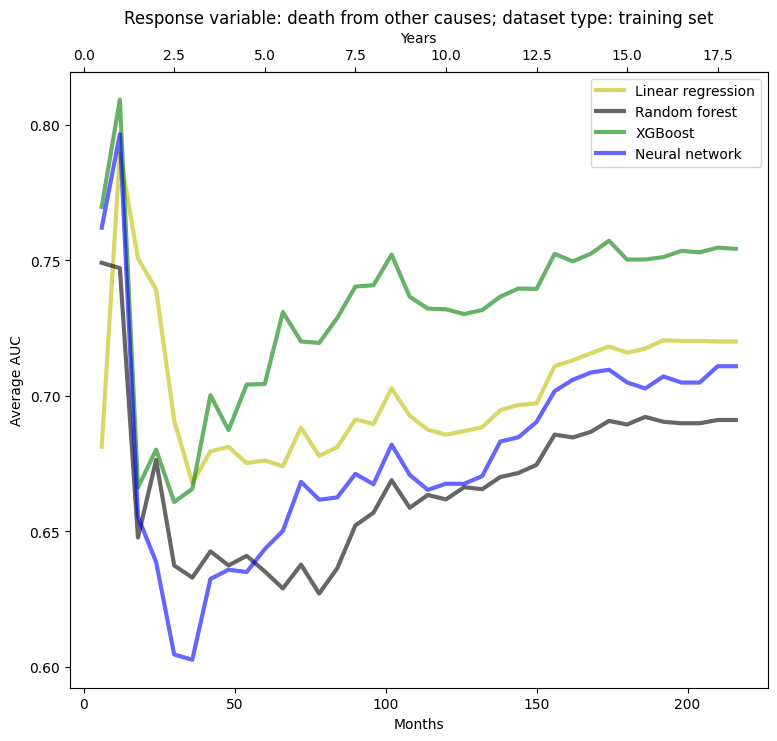

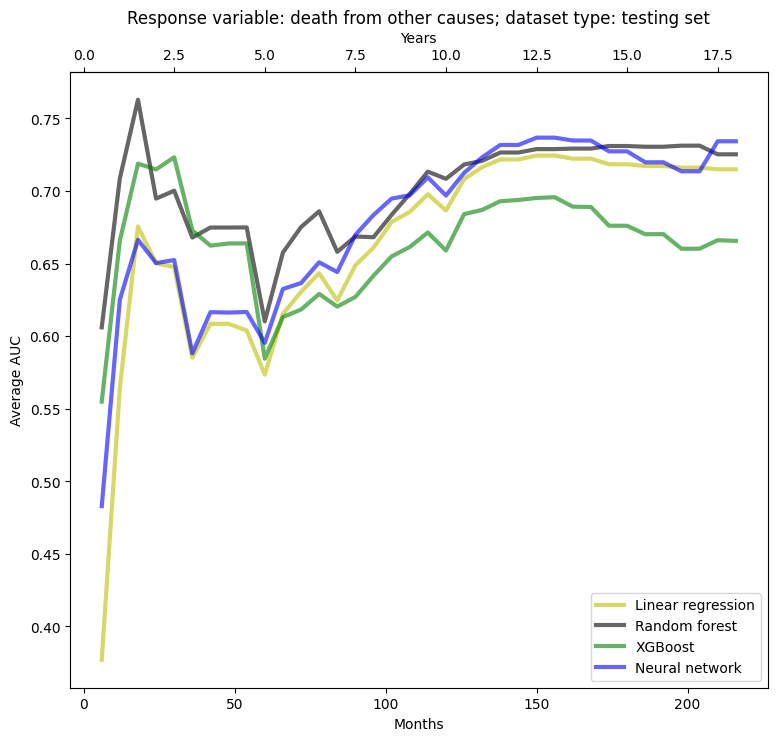

In [27]:
lr_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'death_from_other_causes') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'LogisticRegression') &
                                (all_auc_statistics.experiment_name == 'defaultExperiment')]

rf_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'death_from_other_causes') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'RandomForestClassifier') &
                                (all_auc_statistics.experiment_name == 'Experiment 002')]

xgb_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'death_from_other_causes') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'XGBClassifier') &
                                (all_auc_statistics.experiment_name == 'defaultExperiment')]

nn_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'death_from_other_causes') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'MLPClassifier') &
                                (all_auc_statistics.experiment_name == 'Experiment 001')]

lr_optimal_aggregated = lr_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
rf_optimal_aggregated = rf_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
xgb_optimal_aggregated = xgb_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
nn_optimal_aggregated = nn_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()

# Plot 
fig, ax = plt.subplots()
fig.set_size_inches(9, 8, forward=True)

ax.plot(lr_optimal_aggregated['month'],lr_optimal_aggregated['train_auc'],
    alpha=0.6,color='y', linewidth=3)
ax.plot(rf_optimal_aggregated['month'],rf_optimal_aggregated['train_auc'],
    alpha=0.6,color='k', linewidth=3)
ax.plot(xgb_optimal_aggregated['month'],xgb_optimal_aggregated['train_auc'],
    alpha=0.6,color='g', linewidth=3)
ax.plot(nn_optimal_aggregated['month'],nn_optimal_aggregated['train_auc'],
    alpha=0.6,color='b', linewidth=3)

ax.legend(['Linear regression', 'Random forest', 'XGBoost', 'Neural network'])

ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
ax2.set_xlabel("Years")

ax.set_xlabel('Months')
ax.set_ylabel('Average AUC')

plt.title('Response variable: death from other causes; dataset type: training set')
plt.savefig('eda/models/death_from_other_causes-training_set.png', dpi=500, bbox_inches='tight')
plt.show()


# Plot 
fig, ax = plt.subplots()
fig.set_size_inches(9, 8, forward=True)

ax.plot(lr_optimal_aggregated['month'],lr_optimal_aggregated['test_auc'],
    alpha=0.6,color='y', linewidth=3)
ax.plot(rf_optimal_aggregated['month'],rf_optimal_aggregated['test_auc'],
    alpha=0.6,color='k', linewidth=3)
ax.plot(xgb_optimal_aggregated['month'],xgb_optimal_aggregated['test_auc'],
    alpha=0.6,color='g', linewidth=3)
ax.plot(nn_optimal_aggregated['month'],nn_optimal_aggregated['test_auc'],
    alpha=0.6,color='b', linewidth=3)

ax.legend(['Linear regression', 'Random forest', 'XGBoost', 'Neural network'])

ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
ax2.set_xlabel("Years")

ax.set_xlabel('Months')
ax.set_ylabel('Average AUC')

plt.title('Response variable: death from other causes; dataset type: testing set')
plt.savefig('eda/models/death_from_other_causes-testing_set.png', dpi=500, bbox_inches='tight')
plt.show()

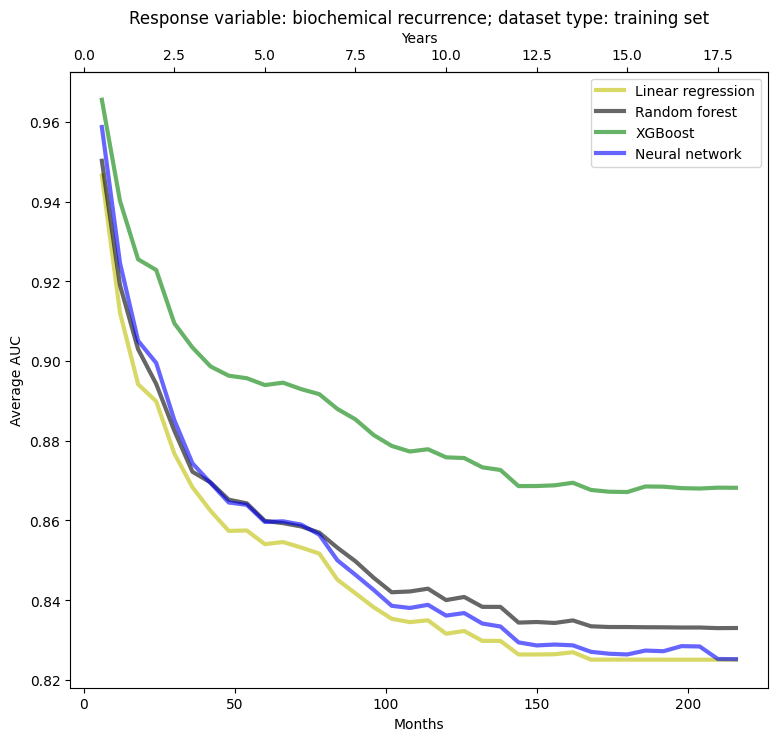

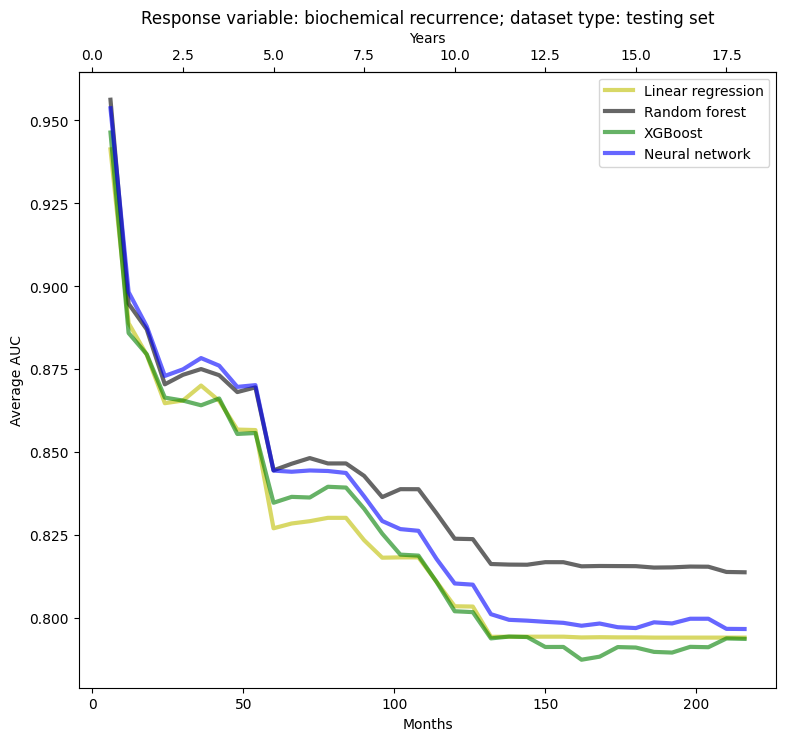

In [28]:
lr_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'bcr') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'LogisticRegression') &
                                (all_auc_statistics.experiment_name == 'defaultExperiment')]

rf_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'bcr') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'RandomForestClassifier') &
                                (all_auc_statistics.experiment_name == 'Experiment C')]

xgb_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'bcr') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'XGBClassifier') &
                                (all_auc_statistics.experiment_name == 'defaultExperiment')]

nn_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'bcr') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'MLPClassifier') &
                                (all_auc_statistics.experiment_name == 'Experiment 001')]

lr_optimal_aggregated = lr_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
rf_optimal_aggregated = rf_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
xgb_optimal_aggregated = xgb_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
nn_optimal_aggregated = nn_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()

# Plot 
fig, ax = plt.subplots()
fig.set_size_inches(9, 8, forward=True)

ax.plot(lr_optimal_aggregated['month'],lr_optimal_aggregated['train_auc'],
    alpha=0.6,color='y', linewidth=3)
ax.plot(rf_optimal_aggregated['month'],rf_optimal_aggregated['train_auc'],
    alpha=0.6,color='k', linewidth=3)
ax.plot(xgb_optimal_aggregated['month'],xgb_optimal_aggregated['train_auc'],
    alpha=0.6,color='g', linewidth=3)
ax.plot(nn_optimal_aggregated['month'],nn_optimal_aggregated['train_auc'],
    alpha=0.6,color='b', linewidth=3)

ax.legend(['Linear regression', 'Random forest', 'XGBoost', 'Neural network'])

ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
ax2.set_xlabel("Years")

ax.set_xlabel('Months')
ax.set_ylabel('Average AUC')

plt.title('Response variable: biochemical recurrence; dataset type: training set')
plt.savefig('eda/models/bcr-training_set.png', dpi=500, bbox_inches='tight')
plt.show()


# Plot 
fig, ax = plt.subplots()
fig.set_size_inches(9, 8, forward=True)

ax.plot(lr_optimal_aggregated['month'],lr_optimal_aggregated['test_auc'],
    alpha=0.6,color='y', linewidth=3)
ax.plot(rf_optimal_aggregated['month'],rf_optimal_aggregated['test_auc'],
    alpha=0.6,color='k', linewidth=3)
ax.plot(xgb_optimal_aggregated['month'],xgb_optimal_aggregated['test_auc'],
    alpha=0.6,color='g', linewidth=3)
ax.plot(nn_optimal_aggregated['month'],nn_optimal_aggregated['test_auc'],
    alpha=0.6,color='b', linewidth=3)

ax.legend(['Linear regression', 'Random forest', 'XGBoost', 'Neural network'])

ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
ax2.set_xlabel("Years")

ax.set_xlabel('Months')
ax.set_ylabel('Average AUC')

plt.title('Response variable: biochemical recurrence; dataset type: testing set')
plt.savefig('eda/models/bcr-testing_set.png', dpi=500, bbox_inches='tight')
plt.show()


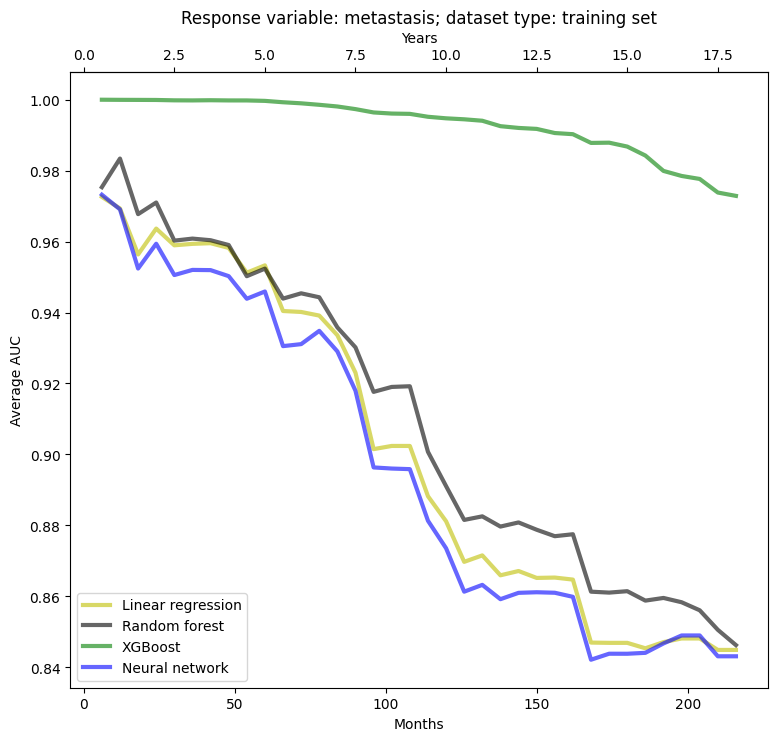

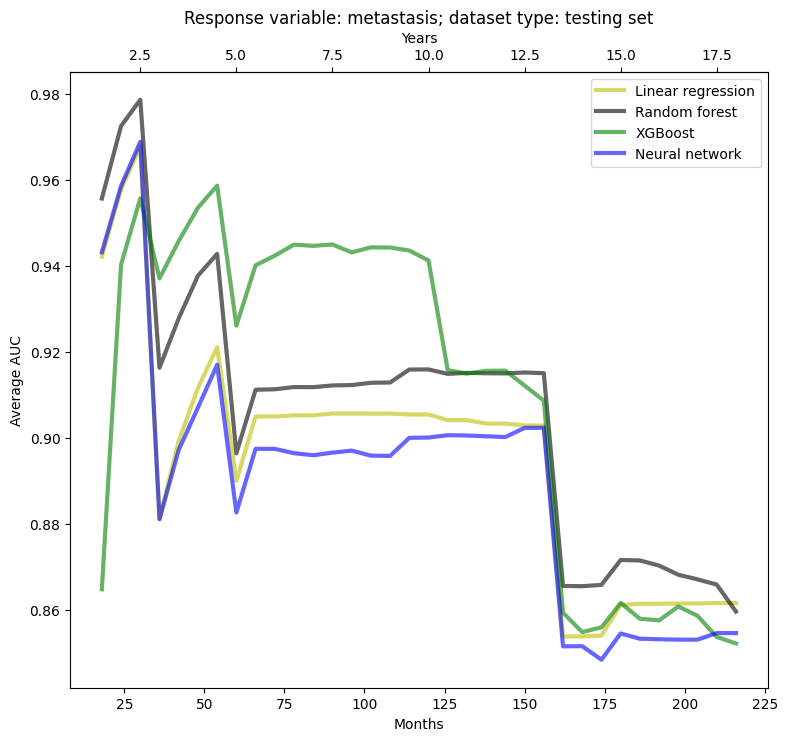

In [29]:
lr_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'mts') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'LogisticRegression') &
                                (all_auc_statistics.experiment_name == 'defaultExperiment')]

rf_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'mts') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'RandomForestClassifier') &
                                (all_auc_statistics.experiment_name == 'defaultExperiment')]

xgb_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'mts') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'XGBClassifier') &
                                (all_auc_statistics.experiment_name == 'Experiment 001')]

nn_optimal = all_auc_statistics[(all_auc_statistics.dataset_type == 'non_homogenous_data') &
                                (all_auc_statistics.target_column == 'mts') &
                                (~all_auc_statistics.months_trained.isin([100, 200])) &
                                (all_auc_statistics.model_name == 'MLPClassifier') &
                                (all_auc_statistics.experiment_name == 'Experiment 002')]

lr_optimal_aggregated = lr_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
rf_optimal_aggregated = rf_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
xgb_optimal_aggregated = xgb_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()
nn_optimal_aggregated = nn_optimal.groupby(['month'], as_index=False)[['train_auc', 'test_auc']].mean()

# Plot 
fig, ax = plt.subplots()
fig.set_size_inches(9, 8, forward=True)

ax.plot(lr_optimal_aggregated['month'],lr_optimal_aggregated['train_auc'],
    alpha=0.6,color='y', linewidth=3)
ax.plot(rf_optimal_aggregated['month'],rf_optimal_aggregated['train_auc'],
    alpha=0.6,color='k', linewidth=3)
ax.plot(xgb_optimal_aggregated['month'],xgb_optimal_aggregated['train_auc'],
    alpha=0.6,color='g', linewidth=3)
ax.plot(nn_optimal_aggregated['month'],nn_optimal_aggregated['train_auc'],
    alpha=0.6,color='b', linewidth=3)

ax.legend(['Linear regression', 'Random forest', 'XGBoost', 'Neural network'])

ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
ax2.set_xlabel("Years")

ax.set_xlabel('Months')
ax.set_ylabel('Average AUC')

plt.title('Response variable: metastasis; dataset type: training set')
plt.savefig('eda/models/mts-training_set.png', dpi=500, bbox_inches='tight')
plt.show()


# Plot 
fig, ax = plt.subplots()
fig.set_size_inches(9, 8, forward=True)

ax.plot(lr_optimal_aggregated['month'],lr_optimal_aggregated['test_auc'],
    alpha=0.6,color='y', linewidth=3)
ax.plot(rf_optimal_aggregated['month'],rf_optimal_aggregated['test_auc'],
    alpha=0.6,color='k', linewidth=3)
ax.plot(xgb_optimal_aggregated['month'],xgb_optimal_aggregated['test_auc'],
    alpha=0.6,color='g', linewidth=3)
ax.plot(nn_optimal_aggregated['month'],nn_optimal_aggregated['test_auc'],
    alpha=0.6,color='b', linewidth=3)

ax.legend(['Linear regression', 'Random forest', 'XGBoost', 'Neural network'])

ax2 = ax.secondary_xaxis("top", functions=(lambda x: x/12, lambda x: 12*x))
ax2.set_xlabel("Years")

ax.set_xlabel('Months')
ax.set_ylabel('Average AUC')

plt.title('Response variable: metastasis; dataset type: testing set')
plt.savefig('eda/models/mts-testing_set.png', dpi=500, bbox_inches='tight')
plt.show()
